# Towards a grid-convergence analysis with cuIBM
---

The present Jupyter-Notebook reports all the simulations used to conduct a independence and convergence analysis of the flying-snake simulation at Reynolds 2000 with the current version of cuIBM.

cuIBM is our in-house C++ code that solves the incompressible Navier-Stokes equations in two dimensions on a single GPU device using the immersed-boundary projection method of Taira and Colonius (2007).

The version of cuIBM used to run the simulations is tagged `snake-repro-cusp-0.5.1` and available on the [GitHub repository](https://github.com/barbagroup/cuIBM/releases/tag/snake-repro-cusp-0.5.1).

cuIBM relies on an external linear algebra library [CUSP](https://github.com/cusplibrary/cusplibrary) (version [0.5.1](https://github.com/cusplibrary/cusplibrary/releases/tag/v0.5.1)) to iteratively solve the velocity and Poisson systems.
In addition, we used CUDA-7.5 to compute on a single GPU card; in this work, we used either K20 or K40 as GPU device.

---
_Warnings:_

1. Some cells in this notebook requires the numerical solution of the flying-snake simulations.
If you do not have the solution,  skip the cell and execute the following one to see the results.

2. Python post-processing scripts to plot the figures make use of the package `snake`, available on [GitHub](https://github.com/mesnardo/snake).

3. cuIBM runs on the finest mesh require a GPU card with at least 6GB of device memory. Here, we used a K40 to compute the numerical solution on the finest grid. (Note: a K20 does not have enough memory to run the finest mesh.)
---

In [1]:
import os
import sys
%matplotlib inline

from IPython.display import Image 

import snake

In [ ]:
print('Python version: {}'.format(sys.version))
print('snake version: {}'.format(snake.__version__))

Last time we ran this notebook, the output of the cell above was:
```
Python version: 2.7.12 |Anaconda 2.5.0 (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
snake version: 0.1.2
```

---
## Table of contents of the directory:
---

* `gridIndependence/`
    - `Re2000AoA30/`: flying-snake at angle-of-attack 30 degrees and Reynolds number 2000.
        + `h0.004/`: simulation reported our manuscript that uses the same input parameters than the one from our previous study (see Krishnan et al., 2014).
        + `h0.006/`: we use a coarser grid with uniform grid-spacing $h=0.006$ in the vicinity of the bluff-body; all other parameters remain identical.
    - `Re2000AoA35/`: flying-snake at angle-of-attack 35 degrees and Reynolds number 2000.
        + `h0.004/`: simulation reported our manuscript that uses the same input parameters than the one from our previous study (see Krishnan et al., 2014).
        + `h0.006/`: we use a coarser grid with uniform grid-spacing $h=0.006$ in the vicinity of the bluff-body; all other parameters remain identical.
        + `h0.006_rtol6/`: same parameters than above, except we use more demanding exit criterion for the iterative solvers (relative tolerance of $10^{-6}$ instead of $10^{-5}$).
        + `h0.006_vatol16_patol5_dt0.0002/`: we use a coarse mesh with $h=0.006$ in the uniform region and a time-increment $\Delta t=0.0002$. The exit criterion for the velocity solver is set to an absolute tolerance of $10^{-16}$ while a value of $10^{-5}$ is used for the Poisson solver.
        + `h0.006_vatol16_patol6_dt0.0002/`: we use a coarse mesh with $h=0.006$ in the uniform region and a time-increment $\Delta t=0.0002$. The exit criterion for the velocity solver is set to an absolute tolerance of $10^{-16}$ while a value of $10^{-8}$ is used for the Poisson solver.
        + `h0.006_vatol16_patol8_dt0.0002/`: we use a coarse mesh with $h=0.006$ in the uniform region and a time-increment $\Delta t=0.0002$. The exit criterion for the velocity solver is set to an absolute tolerance of $10^{-16}$ while a value of $10^{-8}$ is used for the Poisson solver.

* `iterativeConvergence/`: we estimate the required exit criterion needed to solve the discrete Poisson system to machine precision. Each sub-folder corresponds to a simulation with a certain absolute tolerance to solve the Poisson system (e.g., `atol10` solve the Poisson system with an absolute tolerance set to $10^{-10}$).

* `temporalConvergence/`: estimation of the temporal order of convergence with three numerical solution on the fine mesh $h=0.00267$ with systematic refinement in the time-increment.
    - `dt2.0E-04/`: $\Delta t=2\times 10^{-4}$.
    - `dt1.0E-04/`: $\Delta t=1\times 10^{-4}$.
    - `dt5.0E-05/`: $\Delta t=5\times 10^{-5}$.

* `gridConvergence/`: we wanted to estimate the spatial order of convergence and the grid-convergence index with the numerical solution on three systematically refined grids.
    - `h0.006/`: grid-spacing $h=0.006$ in the uniform region surrounding the bluff-body.
    - `h0.004/`: grid-spacing $h=0.004$ in the uniform region surrounding the bluff-body.
    - `h0.00267/`: grid-spacing $h=0.00267$ in the uniform region surrounding the bluff-body.

---
## Grid-independence analysis
---

Krishnan et al. (2014) reported grid-independence in the solution at Reynolds number $Re=2000$ and angles of attack $AoA=30$ and $35$ degrees.
To do that, they computed the solution on two grids with a different grid-spacings in the uniform region ($h=0.004$ and $h=0.006$).
Outside the uniform region, the mesh is stretched to the domain boundaries with a constant ratio of $1.01$.

The two tables below display the relative differences in the time-averaged force coefficients between the two mesh levels.

* $Re=2000$ and $AoA=30^o$:

| h | Avg. $C_d$ | $\Delta C_d / C_d$ | Avg. $C_l$ | $\Delta C_l / C_l$ |
|:-:|:-:|:-:|:-:|:-:|
| $0.006$ | $0.964$ |  | $1.533$ |  |
| $0.004$ | $0.967$ | $+0.3\%$ | $1.532$ | $-0.07\%$ |

* $Re=2000$ and $AoA=35^o$:

| h | Avg. $C_d$ | $\Delta C_d / C_d$ | Avg. $C_l$ | $\Delta C_l / C_l$ |
|:-:|:-:|:-:|:-:|:-:|
| $0.006$ | $1.280$ |  | $2.098$ |  |
| $0.004$ | $1.316$ | $+2.7\%$ | $2.147$ | $+2.3\%$ |

The "small" relative differences obtained led Krishnan and co-workers to conclude that the solution on a grid with $h=0.004$ was sufficiently accurate.

Here, we start by conducting the same grid-independence analysis using a newer version of [cuIBM](https://github.com/barbagroup/cuIBM/releases/tag/snake-repro-cusp-0.5.1) and a newer version of the linear algebra library [CUSP](https://github.com/cusplibrary/cusplibrary/releases/tag/v0.5.1).

* $Re=2000$ and $AoA=30^o$:

We computed the solution at Reynolds number 2000 and angle-of-attack 30 degrees on two grids with different grid-spacing in the uniform region ($h=0.004$ and $h=0.006$) using the same input parameters than those reported in the previous study.

The next cell executes a Python script named `plotForceCoefficientsCompareMeshes.py` that requires the numerical solution on the two meshes.
We provide all the input files necessary to re-run the simulations.
They are located in the folder `cuibm/gridIndependence/Re2000AoA30`.
Using a GPU K20, it tooks us about 34 hours and 58 hours to compute up to 80 time-units of flow-simulation on grids with $h=0.006$ and $h=0.004$, respectively.
If you do not have the numerical solutions, you may skip the next cell and execute the one after to display the instantaneous force coefficients.

In [ ]:
# WARNING: execute this cell if you have the numerical solution
# for the simulation located in:
# - `cuibm/gridIndependence/Re2000AoA30/h0.006`
# - `cuibm/gridIndependence/Re2000AoA30/h0.004`
script = os.path.join('gridIndependence',
                      'Re2000AoA30',
                      'plotForceCoefficientsCompareMeshes.py')
%run $script

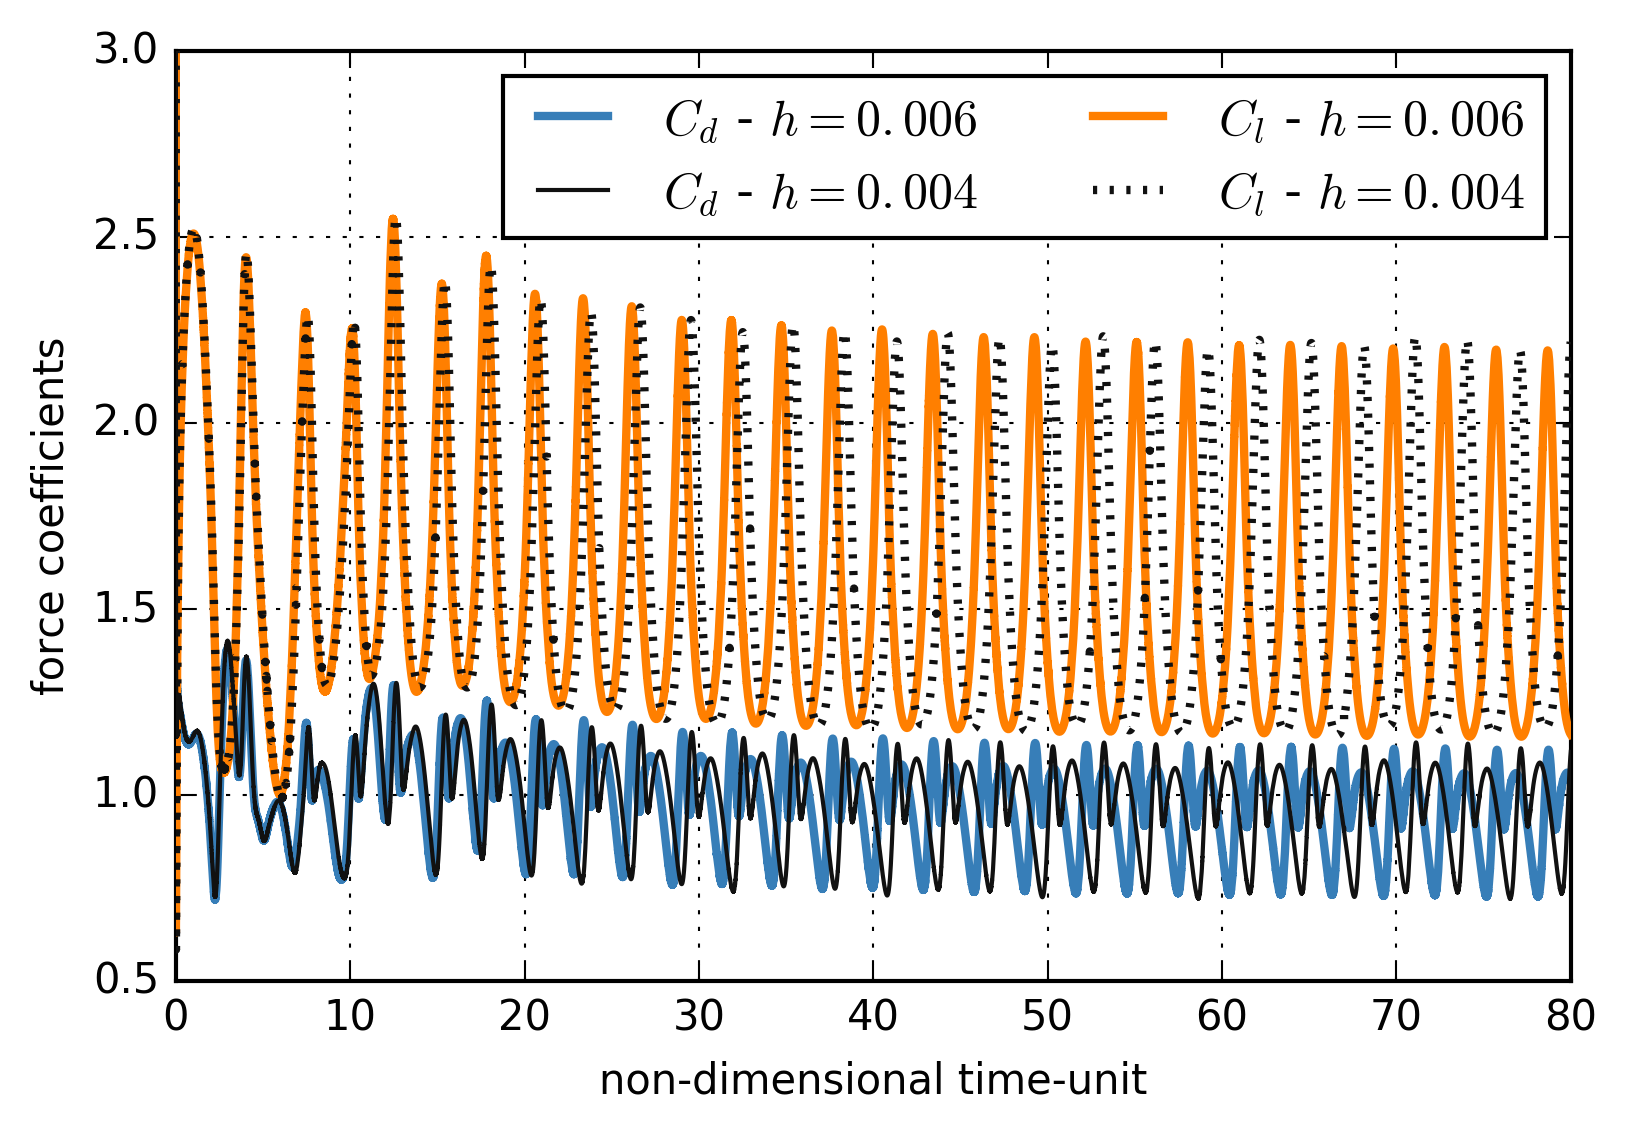

In [2]:
Image(os.path.join('gridIndependence',
                   'Re2000AoA30',
                   'forceCoefficientsCompareMeshes.png'))

We averaged the force coefficients between 32 and 64 time-units of flow-simulation and got similar relative differences between the two mesh levels compared to the values reported in Krishnan et al. (2014):

| h | Avg. $C_d$ | $\Delta C_d / C_d$ | Avg. $C_l$ | $\Delta C_l / C_l$ |
|:-:|:-:|:-:|:-:|:-:|
| $0.006$ | $0.9627$ |  | $1.5331$ |  |
| $0.004$ | $0.9673$ | $-0.47\%$ | $1.5342$ | $-0.07\%$ |

* $Re=2000$ and $AoA=35^o$:

We then increased the angle-of-attack of the bluff-body from 30 to 35 degrees, and computed the solution on the two mesh levels while keeping the same input parameters.
Specifically, we used the same relative tolerance of $10^{-5}$ as exit criterion for the velocity and Poisson solvers.

The next cell executes a Python script named `plotForceCoefficientsCompareMeshes.py` that requires the numerical solution on the two meshes.
We provide all the input files necessary to re-run the simulations.
They are located in the folder `cuibm/gridIndependence/Re2000AoA35`.
Using a GPU K20, it tooks us about 31 hours and 66 hours to compute up to 80 time-units of flow-simulation on grids with $h=0.006$ and $h=0.004$, respectively.
If you do not have the numerical solutions, you may skip the next cell and execute the one after to display the instantaneous force coefficients.

In [ ]:
# WARNING: execute this cell if you have the numerical solution
# for the simulation located in:
# - `cuibm/gridIndependence/Re2000AoA35/h0.006`
# - `cuibm/gridIndependence/Re2000AoA35/h0.004`
script = os.path.join('gridIndependence',
                      'Re2000AoA35',
                      'plotForceCoefficientsCompareMeshes.py')
%run $script

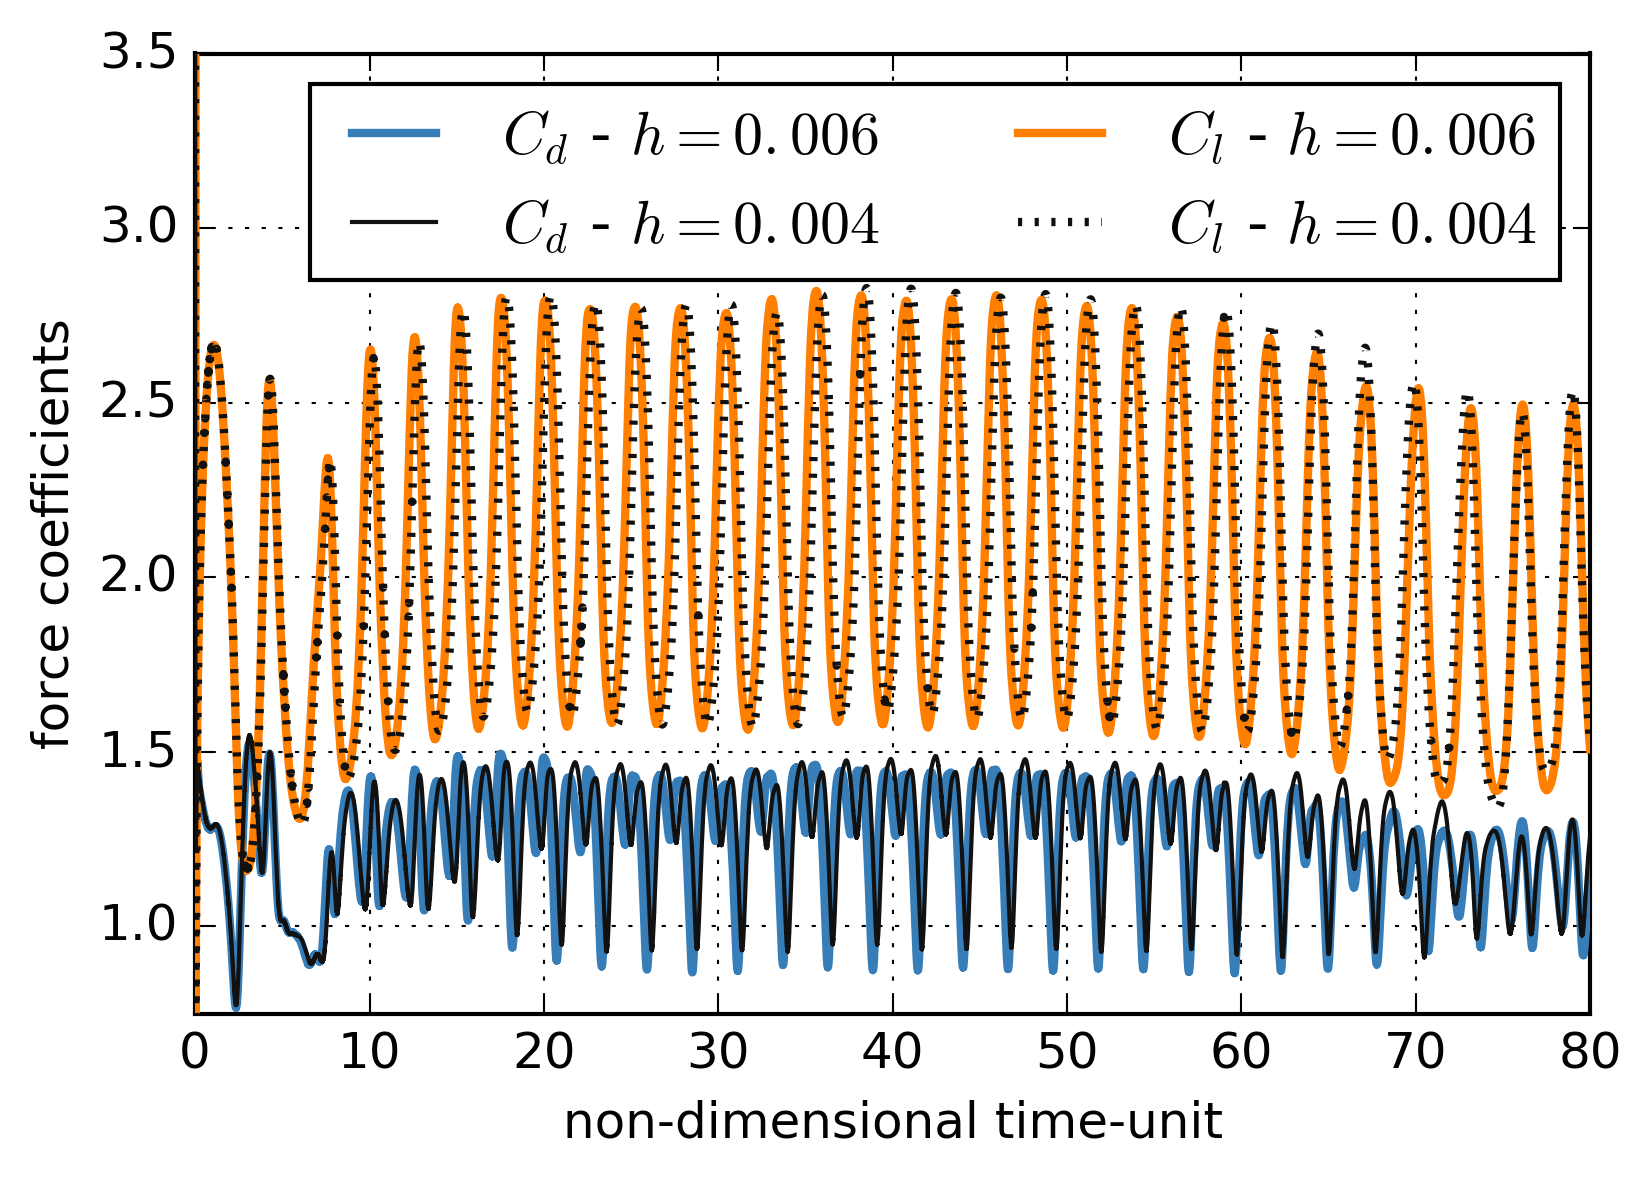

In [3]:
Image(os.path.join('gridIndependence',
                   'Re2000AoA35',
                   'forceCoefficientsCompareMeshes.png'))

On the coarser mesh level, we observe a drop in the mean force coefficients over the course of the simulation, starting at about 35 time-units.
Thus, the time-averaged lift coefficient between 32 and 64 time-units, quantity of interest in the our study, is about $10%$ smaller than the value obtained on the finer mesh level:

| h | Avg. $C_d$ | $\Delta C_d / C_d$ | Avg. $C_l$ | $\Delta C_l / C_l$ |
|:-:|:-:|:-:|:-:|:-:|
| $0.006$ | $1.1905$ |  | $1.9122$ |  |
| $0.004$ | $1.3049$ | $-8.77\%$ | $2.1203$ | $-9.81\%$ |

To check that the systems were iteratively solved with enough accuracy, we computed the solution on the coarse mesh with more demanding exit criterion for the solvers: we decreased the relative tolerance by one order of magnitude (from $10^{-5}$ to $10^{-6}$).

The next cell executes a Python script named `plotForceCoefficientsCompareRTol.py` that requires the numerical solution on the two meshes.
We provide all the input files necessary to re-run the simulations.
They are located in the folder `cuibm/gridIndependence/Re2000AoA35`.
Using a GPU K20, it tooks us about 31 hours and 73 hours to compute up to 80 time-units of flow-simulation on the coarse grid with relative tolerances of $10^{-5}$ and $10^{-6}$, respectively.
If you do not have the numerical solutions, you may skip the next cell and execute the one after to display the instantaneous force coefficients.

In [ ]:
# WARNING: execute this cell if you have the numerical solution
# for the simulation located in:
# - `cuibm/gridIndependence/Re2000AoA35/h0.006`
# - `cuibm/gridIndependence/Re2000AoA35/h0.006_rtol6`
script = os.path.join('gridIndependence',
                      'Re2000AoA35',
                      'plotForceCoefficientsCompareRTol.py')
%run $script

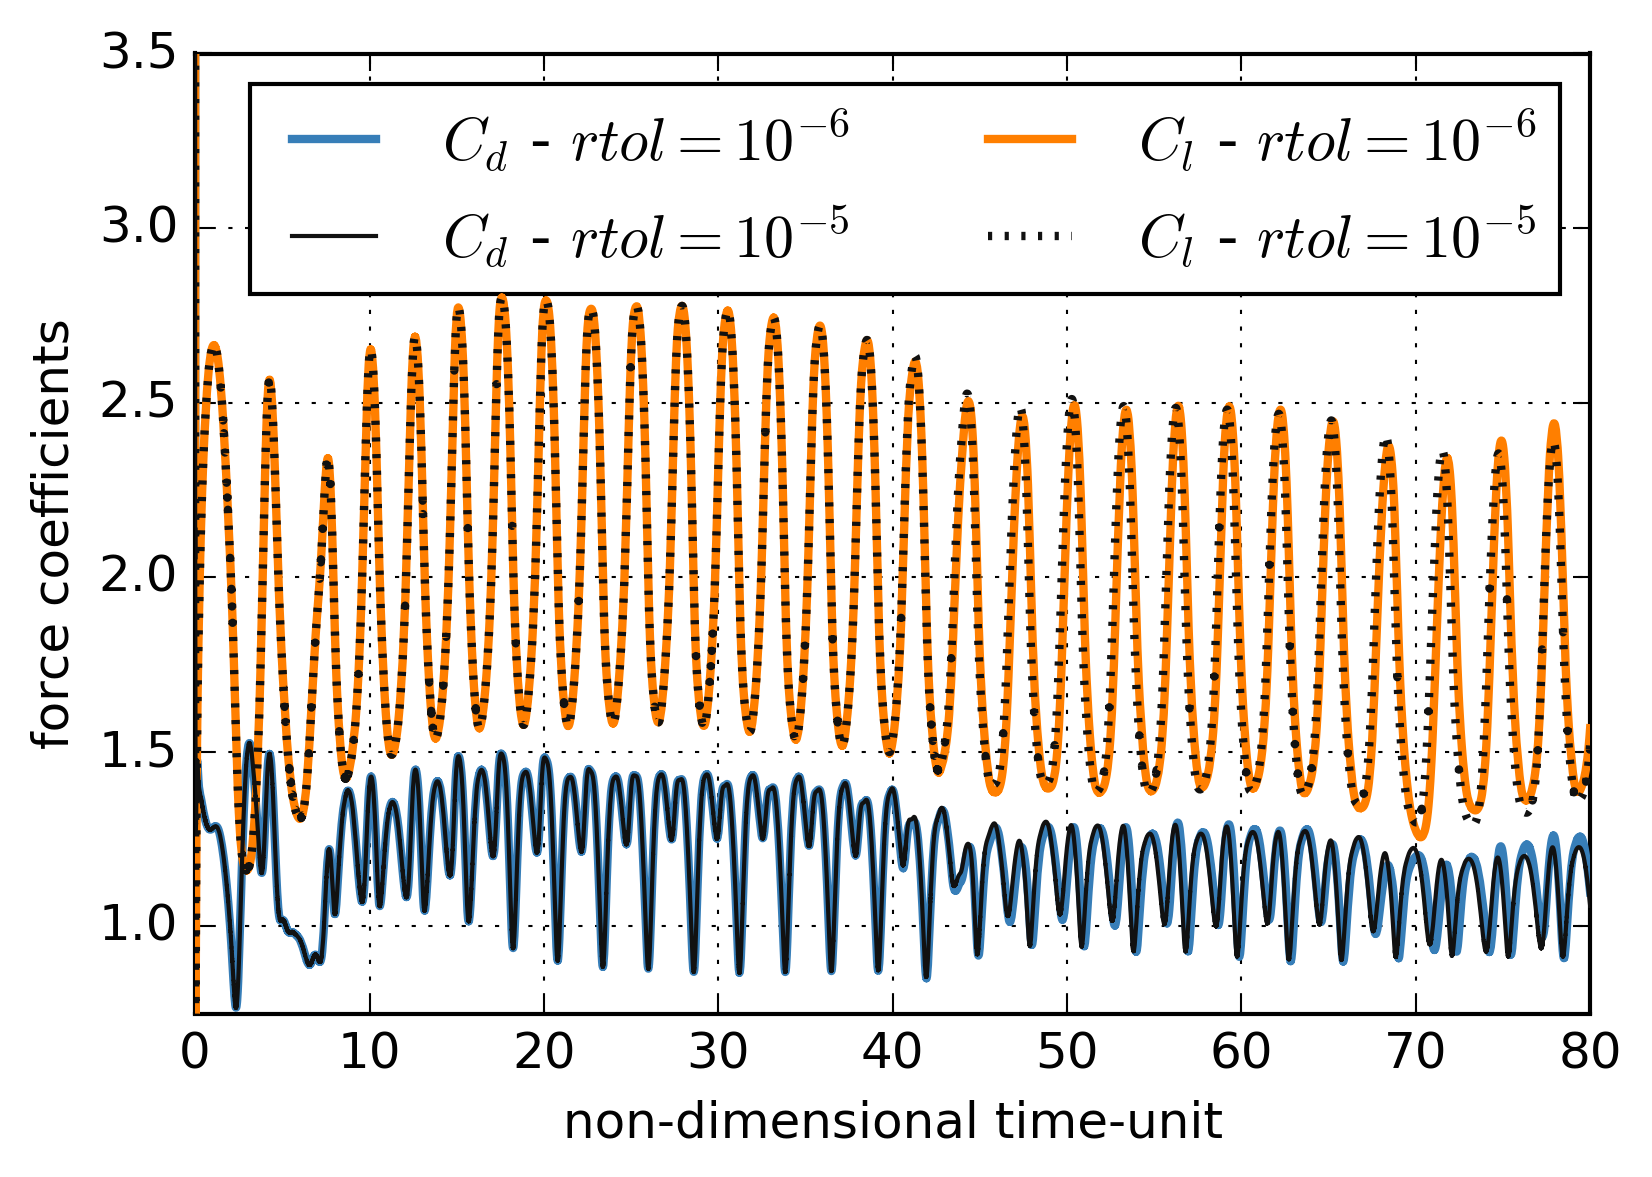

In [4]:
Image(os.path.join('gridIndependence',
                   'Re2000AoA35',
                   'forceCoefficientsCompareRTol.png'))

The instantaneous force coefficients closely match the ones obtained with loose relative tolerances and the relative difference in the time-averaged coefficients is negligible:

| rtol | Avg. $C_d$ | $\Delta C_d / C_d$ | Avg. $C_l$ | $\Delta C_l / C_l$ |
|:-:|:-:|:-:|:-:|:-:|
| $10^{-5}$ | $1.1905$ |  | $1.9122$ |  |
| $10^{-6}$ | $1.1871$ | $-0.29\%$ | $1.9086$ | $-0.19\%$ |

At that point, we conclude we are not able to replicate the grid-independence in the time-averaged lift coefficient at Reynolds number 2000 and angle-of-attack 35 degrees, when using the same parameters than in our previous study.

We use the same software, cuIBM, and the same input files, but we are not able to replicate the grid-independence anlysis...
What is different between the two studies?
Well, cuIBM was augmented with new features, the GPU device is different, and the version of the external linear algebra library changed too.

---
## Looking at the exit criterion for the Poisson solver
---

We decided to investigate the effect of the exit criterion for the Poisson solver on the numerical solution on the coarse grid.
To do that, we set the exit criterion of the velocity solver with an absolute tolerance of $10^{-16}$ and varied the one for the Poisson solver ($10^{-5}$, $10^{-6}$, and $10^{-8}$).
In addition, we used a time-increment twice smaller than the one reported in our previous study to minimize temporal errors.

The next cell runs a Python script named `plotForceCoefficientsCompareATol.py` that requires the numerical solution of the simulation using $10^{-5}$ and $10^{-6}$ as absolute tolerance for the Poisson solver.
The input files necessary to re-compute the solutions are located in the folders `cuibm/gridIndependence/Re2000AoA35/h0.006_vatol16_patol5_dt0.002` and `cuibm/gridIndependence/Re2000AoA35/h0.006_vatol16_patol6_dt0.002`.
Using a GPU K20, it tooks us about 14 hours and 25 hours to compute up to 80 time-units of flow-simulation on the coarse grid with absolute tolerances of $10^{-5}$ and $10^{-6}$, respectively.
If you do not have the numerical solutions, you may skip the next cell and execute the one after to display the instantaneous force coefficients.

In [ ]:
# WARNING: execute this cell if you have the numerical solution
# for the simulation located in:
# - `cuibm/gridIndependence/Re2000AoA35/h0.006_vatol16_patol5_dt0.002`
# - `cuibm/gridIndependence/Re2000AoA35/h0.006_vatol16_patol6_dt0.002`
script = os.path.join('gridIndependence',
                      'Re2000AoA35',
                      'plotForceCoefficientsCompareATol.py')
%run $script

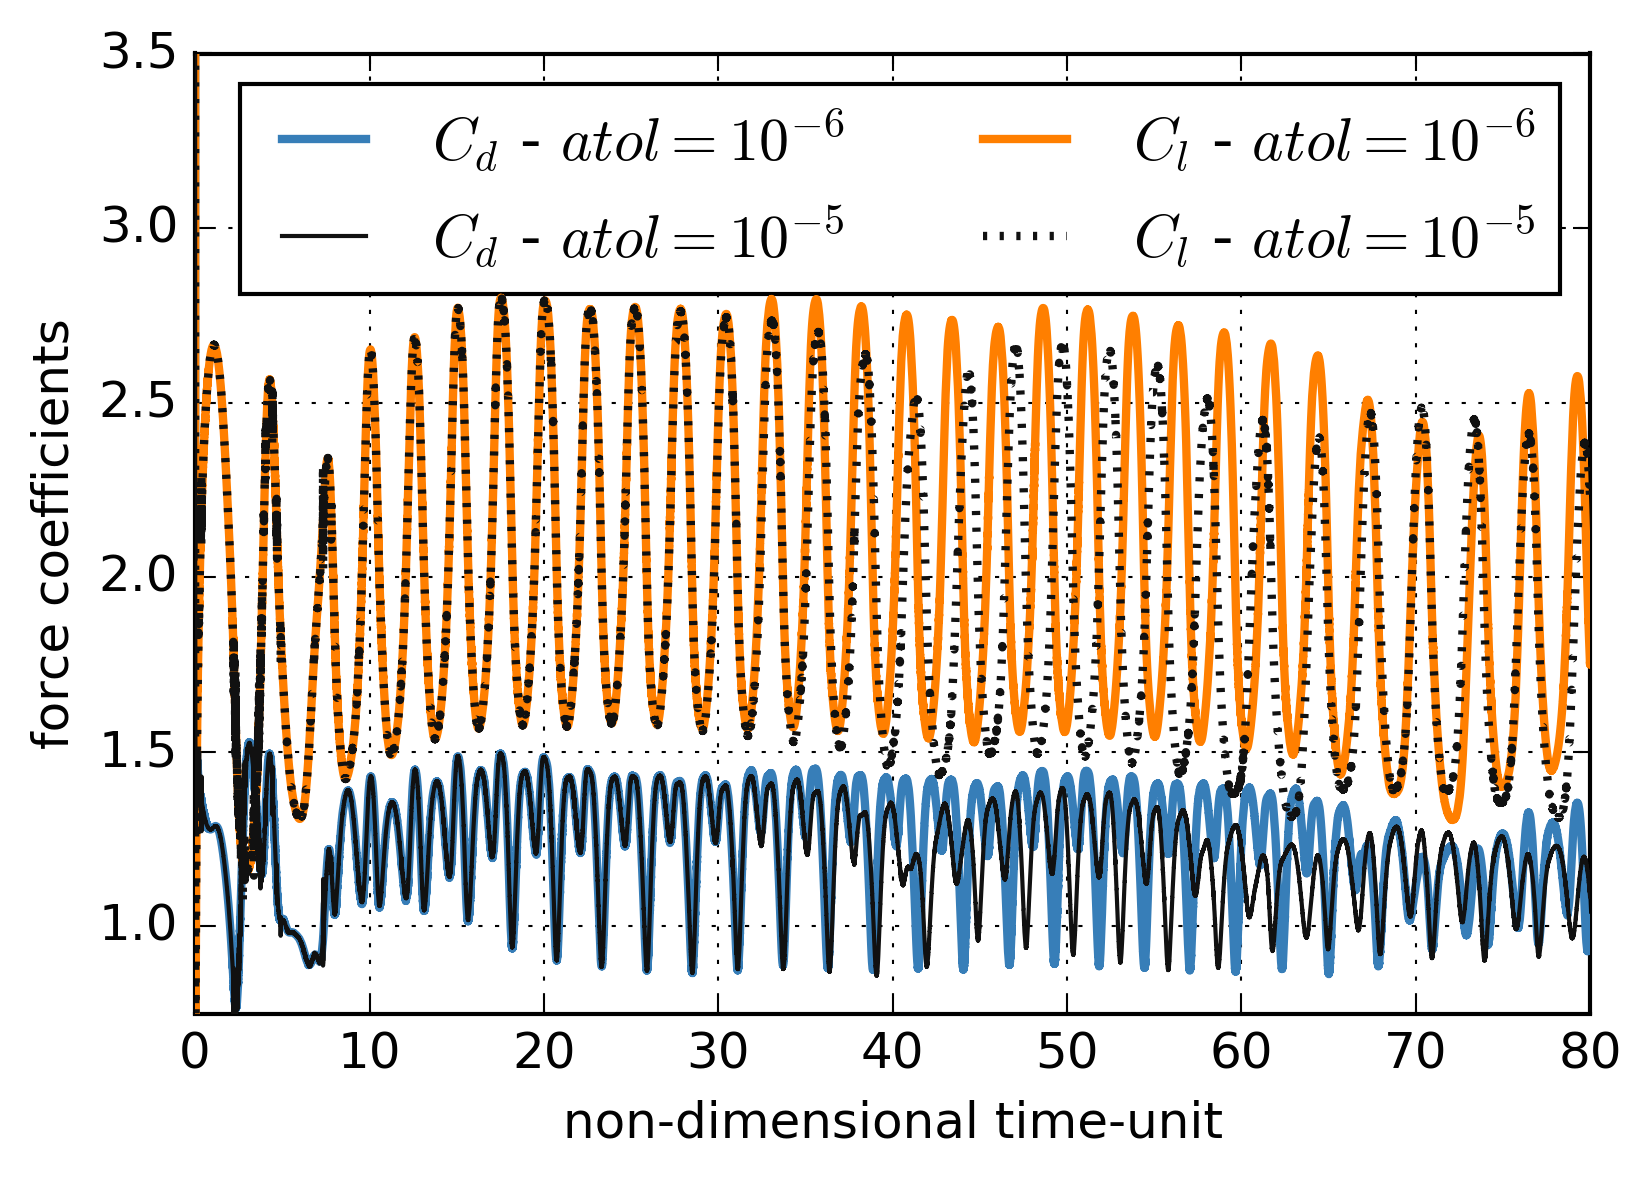

In [5]:
Image(os.path.join('gridIndependence',
                   'Re2000AoA35',
                   'forceCoefficientsCompareATol.png'))

In [ ]:
# WARNING: execute this cell if you have computed the numerical solutions
script = os.path.join('gridIndependence',
                      'Re2000AoA35',
                      'plotForceCoefficientsCompareATol2.py')
%run $script

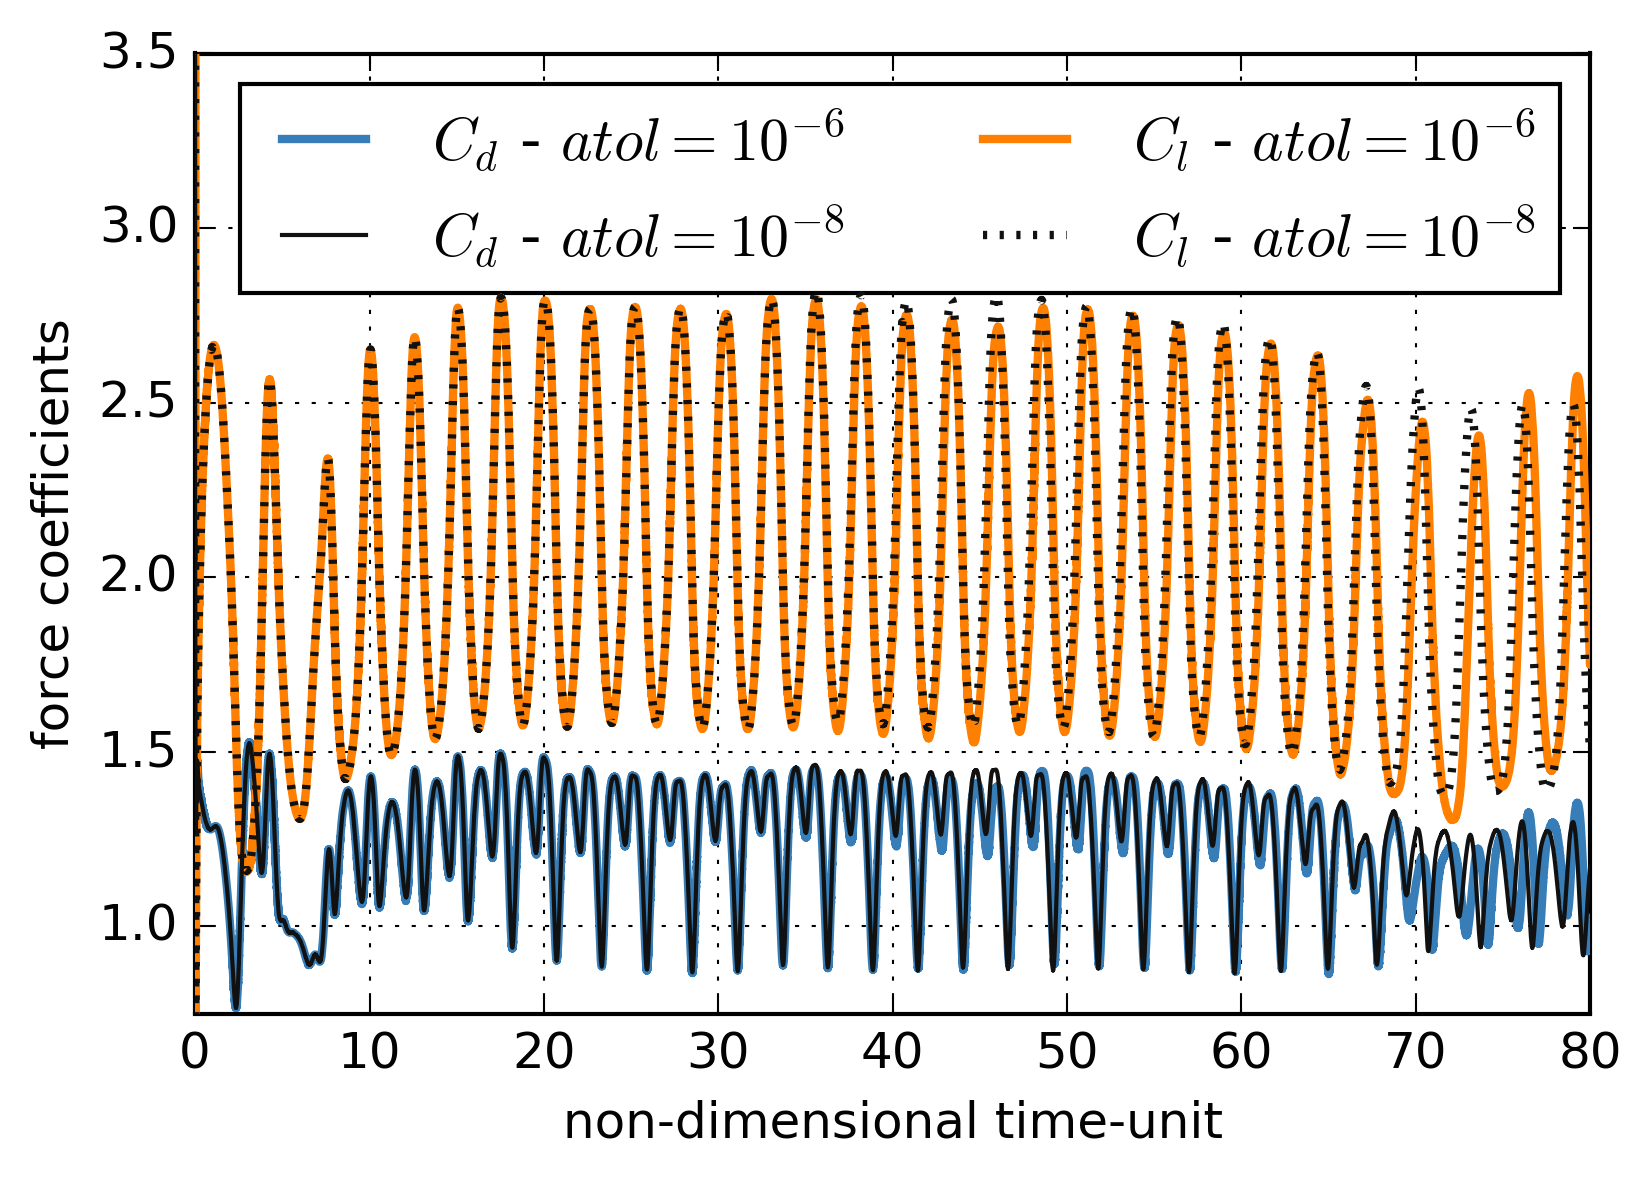

In [6]:
Image(os.path.join('gridIndependence',
                   'Re2000AoA35',
                   'forceCoefficientsCompareATol2.png'))

When averaging the force coefficients between 32 and 64 time-units, we get:

| atol | Avg. $C_d$ | $\Delta C_d / C_d$ | Avg. $C_l$ | $\Delta C_l / C_l$ |
|:-:|:-:|:-:|:-:|:-:|
| $10^{-8}$ | $1.2838$ |  | $2.1229$ |  |
| $10^{-6}$ | $1.2740$ | $-0.76\%$ | $2.0934$ | $-1.39\%$ |
| $10^{-5}$ | $1.2095$ | $-5.79\%$ | $1.9531$ | $-8.00\%$ |

Going back to our grid-independence analysis, we now compare the solution on the finer mesh level ($h=0.004$), with relative tolerances of $10^{-5}$, and a time-increment of $0.0004$, with the solution on the coarser mesh level ($h=0.006$), with an absolute tolerance of $10^{-8}$ for the Poisson solver, and a time-increment of $0.0002$.

Averaging the force coefficients between 32 and 64 time-units, we get:

| h | Avg. $C_d$ | $\Delta C_d / C_d$ | Avg. $C_l$ | $\Delta C_l / C_l$ |
|:-:|:-:|:-:|:-:|:-:|
| $0.004$ | $1.3049$ |  | $2.1203$ |  |
| $0.006$ | $1.2838$ | $-1.62\%$ | $2.1229$ | $+0.12\%$ |

At that point, we consider we achieved grid-independence in the time-averaged force coefficients at Reynolds number 2000 and angles of attack 30 and 35 degrees.

We note that a grid-independence study is not as rigorous as a grid-convergence analysis, as the former does not necessarily mean the solution obtained with a grid is in the asymptotic range.

To conduct a grid-convergence study, we need a way to estimate the discretization error.
One possibility is to use the grid-convergence index technique from Roache (1997).
This methods requires to calculate a Richardson extrapolation based on the solution from two systematically refined grids and the order of convergence of the method.

Although the Navier-Stokes solver implemented in cuIBM has a formal second-order order of convergence, the immersed-boundary technique, the boundary conditions, and the stretching ratio of the grid may alter it.
Instead of using the formal value, we can evaluate the observed order of convergence of the solution; this requires the numerical solution on three systematically refined grids.

Systematic mesh refinement requires uniformity in the refinement as well as consistency (i.e., the quality of the mesh should not be deteriorated with refinement).
Note that uniform refinement does not impose the mesh itself to be uniform.

Here, we would like to assess grid-convergence in the solution using three mesh levels with grid-spacings $h=0.006$, $0.004$, and $0.00267$ (refinement ratio of $1.5$) in the uniform sub-region of the domain.
Outside this region, the gridlines are stretched until the domain boundaries with a constant ratio of $1.01$.

Prior estimating the discretization error, we need to ensure the total error will not be dominated by iterative and temporal errors.

---
## Iterative-convergence analysis
---

To evaluate the iterative error, we computed the solution on the finest mesh ($h=0.00267$) over a small number of time-steps with time-increment $\Delta t=10^{-4}$.
We fixed to exit criterion of the velocity solver with an absolute tolerance of $10^{-16}$ and varied the one for the Poisson solver (between $10^{-5}$ and $10^{-16}$).
To avoid the transient regime due to the impulsively start, we first computed $1000$ time-steps ($0.1$ non-dimensional time-unit) using smallest absolute tolerance for the Poisson solver.
The solution at $0.1$ time-unit was then used to compute an extra $500$ time-steps for each absolute tolerance of the Poisson solver.

We consider the solution obtained with the smallest absolute tolerance as the machine-accurate one.
At time-step 1500, we compare the differences in the forces, the flux fields, and the pressure fields from each run with the machine-accurate solution.

The next cell runs a Python script named `plotIterativeErrors.py` that plots the errors in the forces, fluxes, and pressure after 1500 time-steps with respect to the machine-accurate solution.
The script requires the numerical solution for each simulation located in the folder `cuibm/iterativeConvergence`.
We used a GPU K40 to run the cases (the problem necessitates a minimum of 6GB of memory on the device).
If you do not have the numerical solutions, you may skip the next cell and execute the one after to display the errors versus the absolute tolerance for the Poisson solver.

In [ ]:
# WARNING: execute this cell if you have the numerical solution
# for each simulation present in the folder 
# `cuibm/iterativeConvergence`
script = os.path.join('iterativeConvergence',
                      'plotIterativeErrors.py')
%run $script

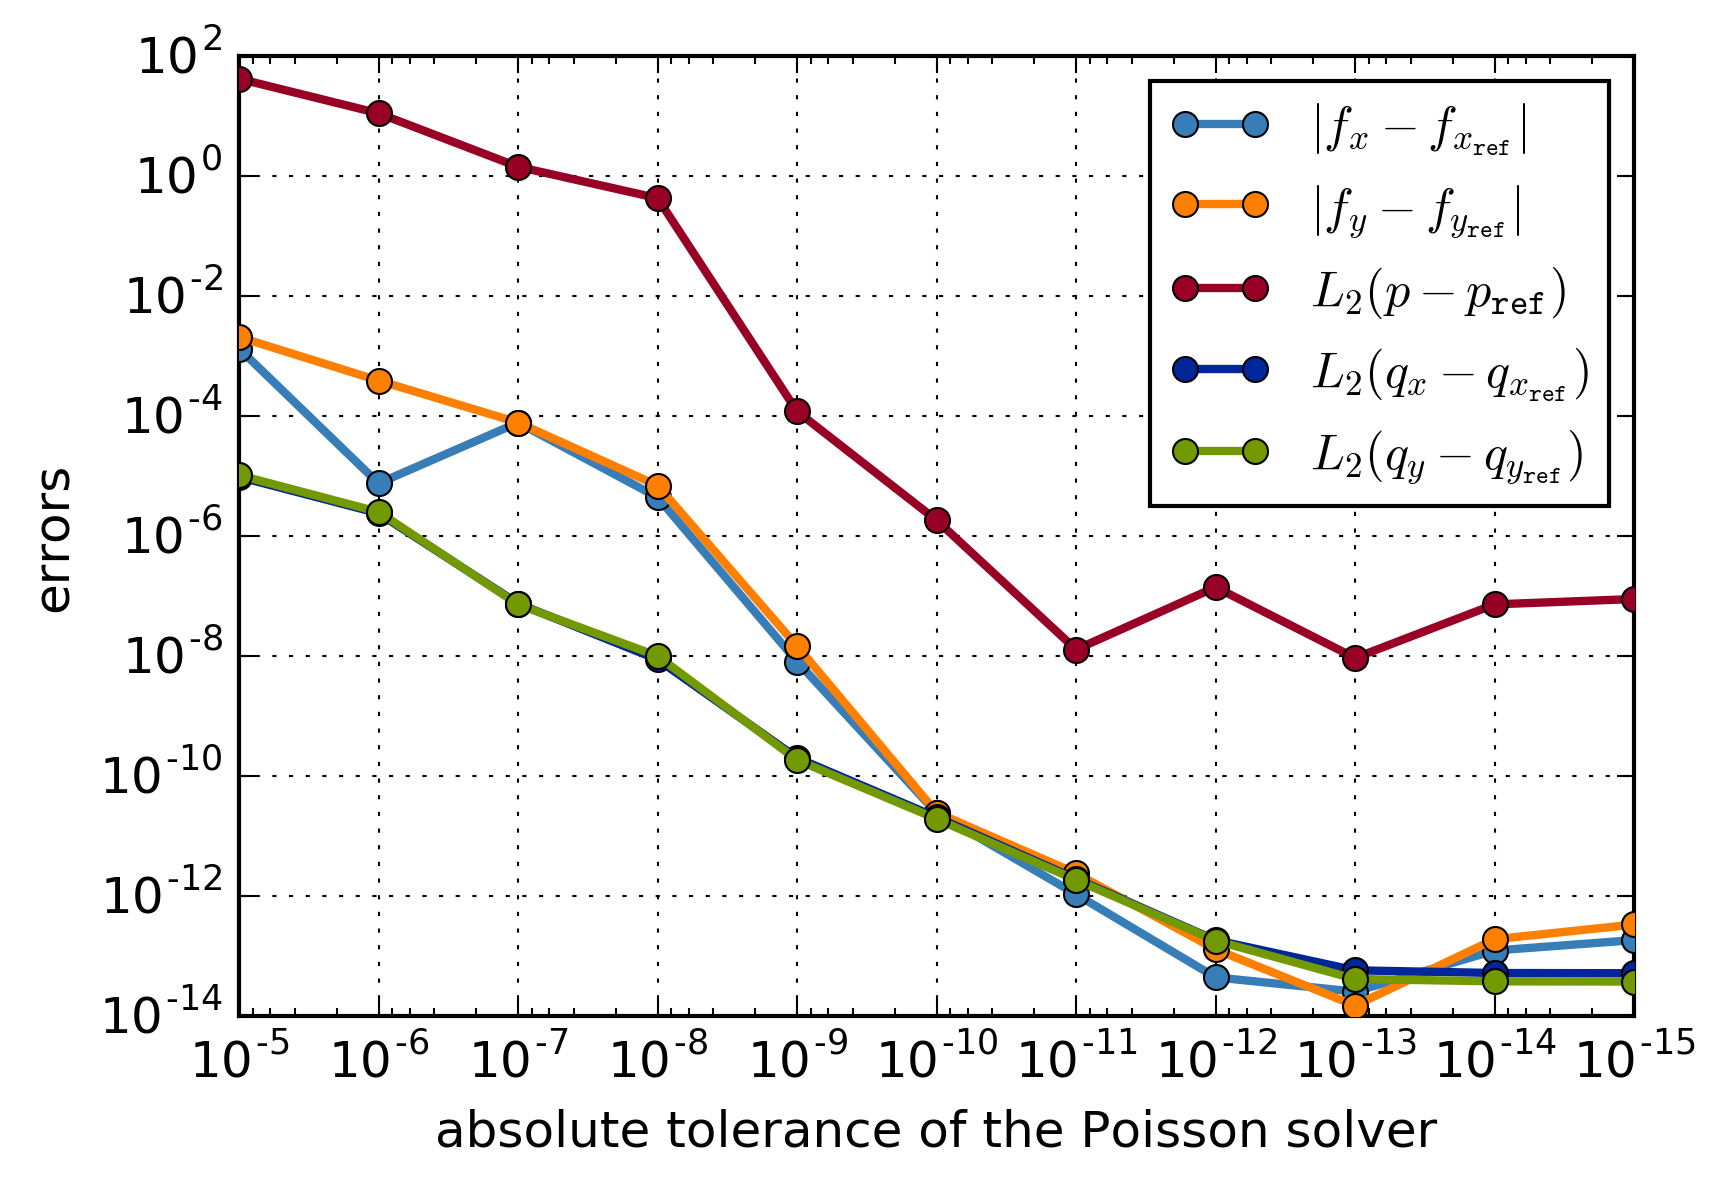

In [7]:
Image(os.path.join('iterativeConvergence',
                   'iterativeErrors.png'))

According to the figure above, the solution for the pressure does not improve (compared to the machine-accurate solution) when using a absolute tolerance smaller than $10^{-11}$ as exit criterion for the Poisson solver.

Using a GPU K40, it took us about 2 hours and 15 minutes to compute 500 time-steps at time-increment $10^{-4}$ with an absolute tolerance of $10^{-11}$.
(Note that about 99% of the time is spent solving the Poisson system.)
The quantity we are trying to replicate in this study is the time-averaged lift coefficient.
Krishnan et al. chose an arbitrary range between 32 and 64 non-dimensional time-units.
Based on the run-time of the iterative-convergence test, we estimate that it would take us about 120 days to compute the solution up to 64 time-units... (SIGH!)

---
## Temporal-convergence analysis
---

We also looked at the temporal error in the solution on the finest grid ($h=0.00267$).
Using the solution after $0.1$ time-unit obtained previously with the smallest absolute tolerances, with computed an extra $0.05$ time-unit of flow simulation with different time-increments: $\Delta t=2\times10^{-4}$, $1\times10^{-4}$, and $5\times10^{-5}$.

We compare forces, pressure, and fluxes at time-unit $0.15$ and calculate the observed order of convergence.

The next cell runs a Python script named `getTemporalConvergence.py` which requires the numerical solution of the following simulations:
* `cuibm/temporalConvergence/dt2.0E-04`,
* `cuibm/temporalConvergence/dt1.0E-04`,
* `cuibm/temporalConvergence/dt5.0E-05`.
We used a GPU K40 to run the cases (the problem necessitates a minimum of 6GB of memory on the device).
If you do not have the numerical solutions, you may skip the next cell and execute the one after to display the errors versus the absolute tolerance for the Poisson solver.

In [ ]:
# WARNING: execute this cell if you have the numerical solution
# of the simulations:
# - `cuibm/temporalConvergence/dt2.0E-04`,
# - `cuibm/temporalConvergence/dt1.0E-04`,
# - `cuibm/temporalConvergence/dt5.0E-05`.
script = os.path.join('temporalConvergence',
                      'getTemporalConvergence.py')
%run $script

In [8]:
results = os.path.join('temporalConvergence',
                       'temporalConvergence.txt')
%cat $results


* Drag force:
Value and relative difference with the reference value (smallest dt)
	dt=5.0E-05: 0.731954695933
	dt=1.0E-04: 0.731922984559 (-0.00433242304222%)
	dt=2.0E-04: 0.731859492565 (-0.013006729631%)
Observed order of convergence: 1.0015743127

* Lift force:
Value and relative difference with the reference value (smallest dt)
	dt=5.0E-05: 0.856144673048
	dt=1.0E-04: 0.856103782052 (-0.00477617835346%)
	dt=2.0E-04: 0.85602173432 (-0.0143595740492%)
Observed order of convergence: 1.0046802272

* Pressure field:
L2-norm of the difference with the reference field (smallest dt)
normalized by the L2-norm of the reference field
	dt=1.0E-04: 0.0016378431644
	dt=2.0E-04: 0.00485593713885
Observed order of convergence: 0.974409721659

* Fluxes in the x-direction:
L2-norm of the difference with the reference field (smallest dt)
normalized by the L2-norm of the reference field
	dt=1.0E-04: 4.25470350102e-07
	dt=2.0E-04: 1.27492019436e-06
Observed order of convergence: 0.997682285416

* Flu

The results above show that the immersed-boundary projection method used in this study is first-order accurate in time, as expected.

Thereforce, with a time-increment of $\Delta t=2\times10^{-4}$ and an abosolute tolerance of $10^{-11}$ as exit criterion for the Poisson solver, we would need about 60 days to compute 64 time-units of flow-simulation on the finest grid... (SIGH!)

At that point, it seems unreasonable to estimate grid-convergence in our quantity of interest, the unsteady lift coefficient averaged between 32 and 64 time-units.

---
## Grid-convergence analysis
---

To assess grid-convregence in the solution, we computed the numerical solution at Reynolds number 2000 and angle-of-attack 35 degrees on our three systematically refined grids using a time-increment $\Delta t=2\times10^{-4}$, an absolute tolerance of $10^{-16}$ for the velocity solver, and an absolute tolerance of $10^{-6}$ for the Poisson solver.

We choose this exit criterion for the Poisson solver based on the small relative differences in the time-averaged force coefficients obtained with the coarsest mesh when decreasing the relative tolerance by two orders of magnitude.

The next cell executes a Python script named `plotForceCoefficients.py` located in the folder `gridConvergence`.
The script reads the forces obtained with the three grids, thus, requires to run the simulations.
We provide all input files necessary to re-run these simulations; they are located in the sub-folders `h0.006`, `h0.004`, and `h0.00267` for the mesh with grid-spacings `0.006`, `0.004`, and `0.00267`, respectively.
In addition, a `README` file, in the same directory, detauls the procedure to run these simulations.
If you do not have the numerical solutions, you can skip the next cell and go directly to the one after to visualize the instantaneous force coefficients we obtained on the three grids.

In [ ]:
# WARNING: execute this cell if you have the numerical solutions
script = os.path.join('gridConvergence',
                      'plotForceCoefficients.py')
%run $script

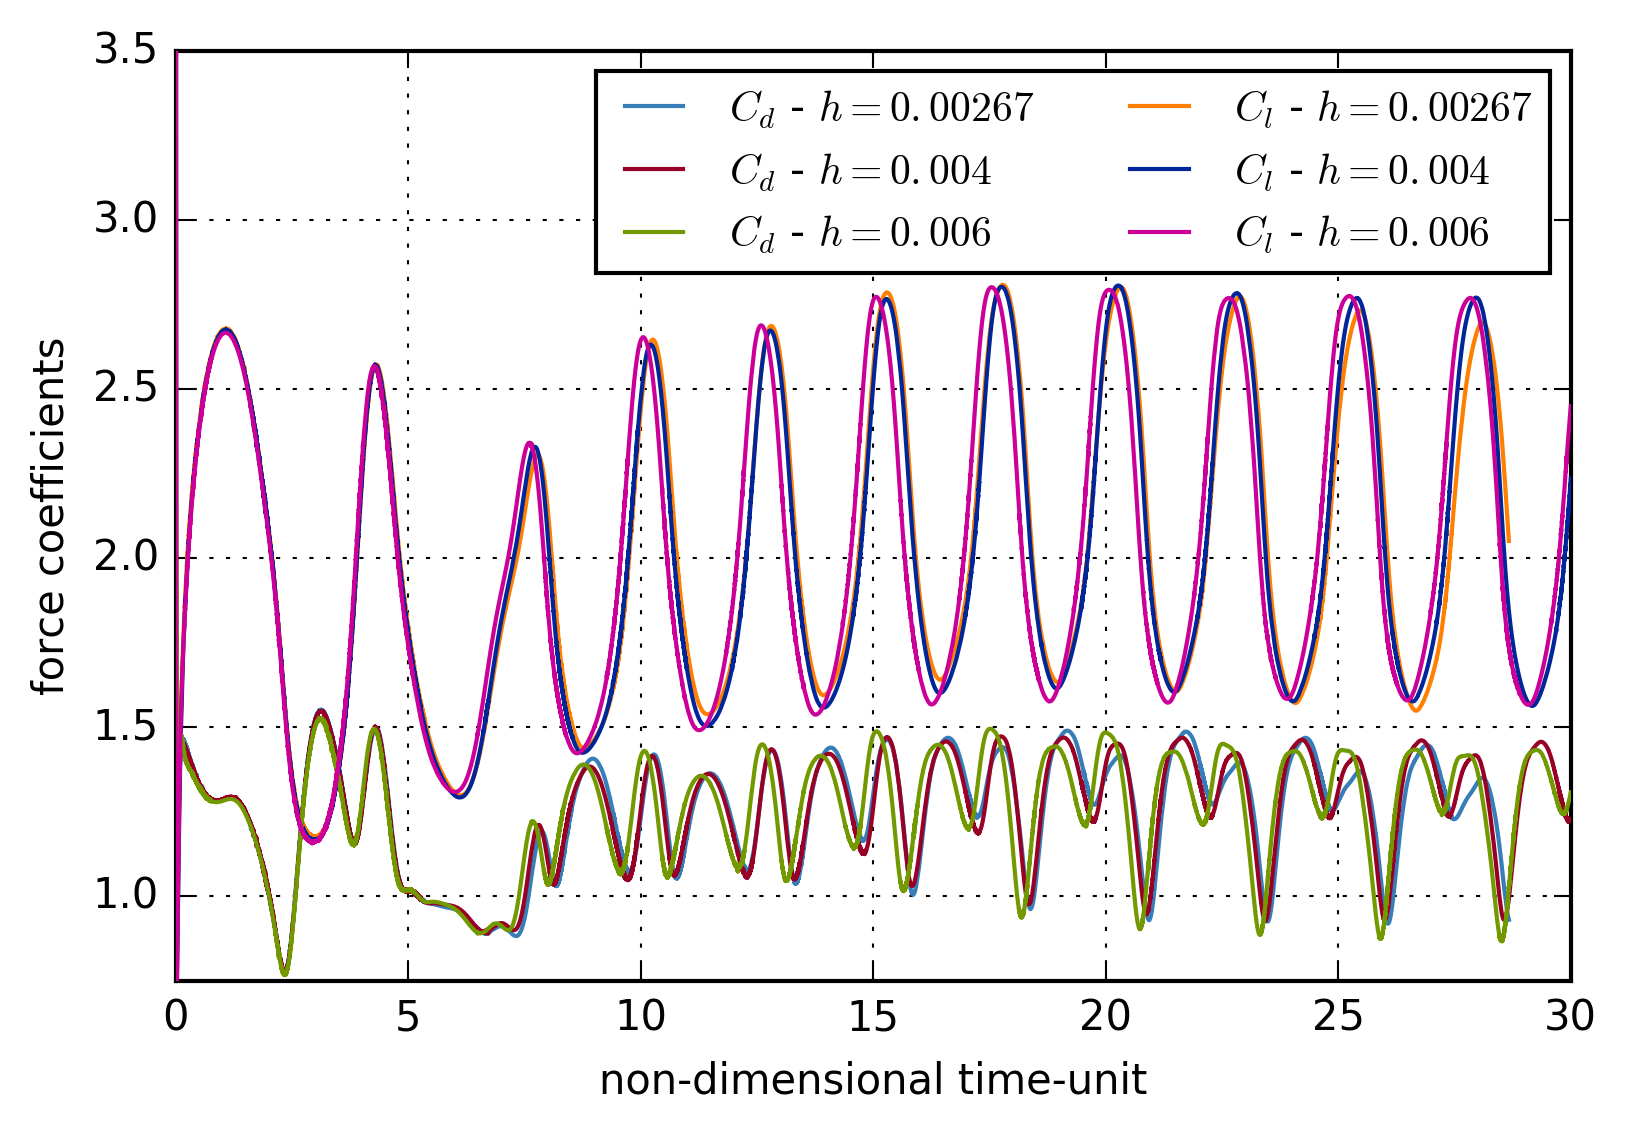

In [9]:
Image(os.path.join('gridConvergence',
                   'forceCoefficients.png'))

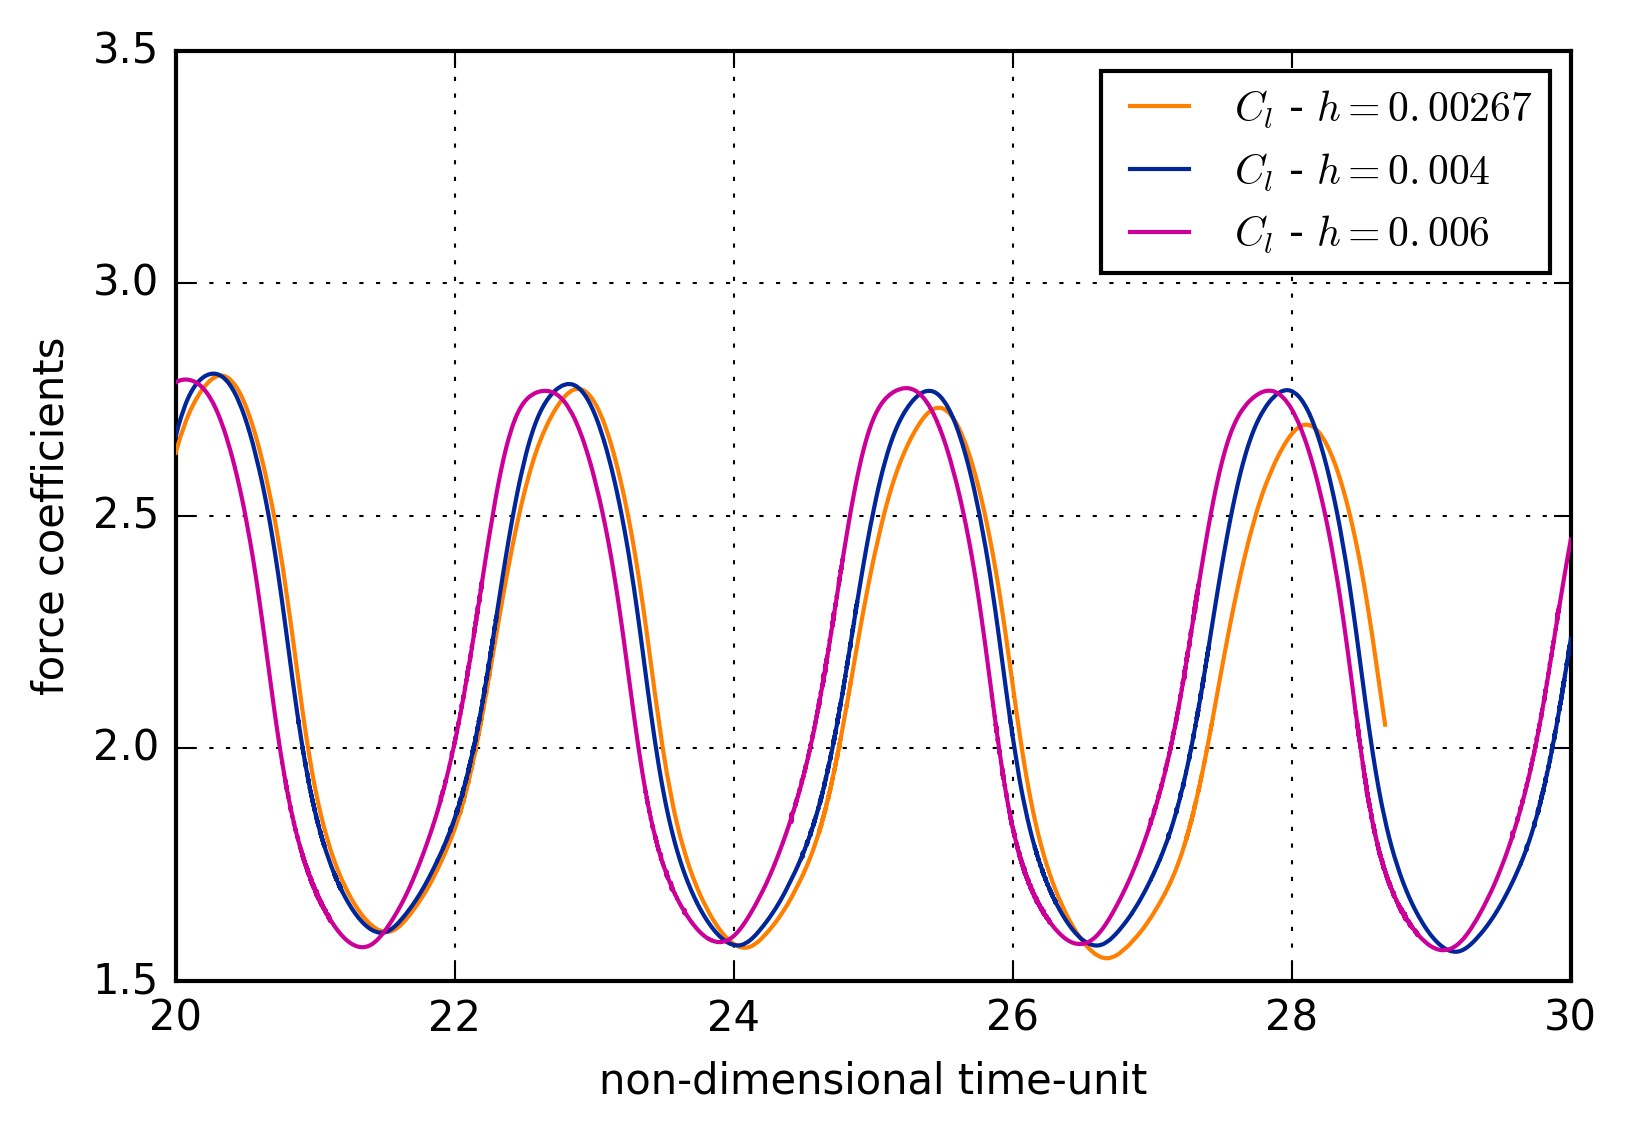

In [10]:
Image(os.path.join('gridConvergence',
                   'forceCoefficientsZoom.png'))

Comparing the instantaneous force coefficients obtained with different mesh levels, one can observed a phase difference in the signals.
This phase difference in the time-dependent solution prevents us from calculating the observed order of convergence at a particular snapshot in time.

The quantity of interest in this study is the lift coefficient averaged between 32 and 64 time-units of flow simulation.
We would like to calculate the grid-convergence index based on this quantity.
To do this, we need to compute the observed order of convergence and the Richardson extrapolation to ,then, apply the grid-convergence index theory of Roache (1997).

However, looking at the temporal zoom in the figure above, we see that the mean lift coefficient (per period) already starts to drop with the finest mesh after 28 time-units.
This drop is caused by a vortex merger happening in the wake of the bluff-body, changing the signature on it: vortices previously aligned (high mean lift coefficient) now adopts a 1S+1P pattern (1 single vortex on the upper part of the wake and a dipole on the bottom).

These discrepancies in the force signals restrict us from calculating the observed order of convergence of our quantity of interest, the time-averaged lift coefficient.

At that point, with cuIBM, we have not been able to achieve a proper grid-convergence analysis. 
But at least, we report grid-independence.

---
#### References:
- Krishnan, A., Socha, J. J., Vlachos, P. P., & Barba, L. A. (2014). Lift and wakes of flying snakes. Physics of Fluids (1994-present), 26(3), 031901.
- P. J. Roache, Quantification of Uncertainty in Computational Fluid Dynamics, Annual Review of Fluid Mechanics, Vol. 29: 123-160 (1997), DOI: 10.1146/annurev.fluid.29.1.123, http://www.annualreviews.org/doi/full/10.1146/annurev.fluid.29.1.123
- Taira, K., & Colonius, T. (2007). The immersed boundary method: a projection approach. Journal of Computational Physics, 225(2), 2118-2137.
---